# 03 · EDA — Cardiovascular

**Purpose**: sanity-check and characterize cardiovascular features (HR/HRV),
validate ETL end-to-end, and produce figures/tables for CA3.

**Inputs**: `features_cardiovascular.csv`, `features_daily_updated.csv`, manifests.
**Outputs**: figures in `eda_outputs/` and `eda_summary.json`.


In [1]:
# --- Project root + paths (fix) ---
from pathlib import Path
import os, shutil

def find_repo_root(start: Path = Path.cwd()) -> Path:
    p = start.resolve()
    for _ in range(8):
        if (p / "etl_modules").exists() or (p / ".git").exists():
            return p
        if p.parent == p:
            break
        p = p.parent
    return start.resolve()

REPO = find_repo_root()
print("REPO ROOT →", REPO)

# keep previously set PID/SNAP if present, else defaults:
PID  = globals().get('PID', 'P000001')
SNAP = globals().get('SNAP', '2025-09-29')

# use repo root for all paths
SNAPDIR = REPO / "data_ai" / PID / "snapshots" / SNAP
OUTDIR  = SNAPDIR / "eda_outputs"
OUTDIR.mkdir(parents=True, exist_ok=True)
print("SNAPDIR →", SNAPDIR)
print("OUTDIR  →", OUTDIR)

# relocate mistakenly created outputs under notebooks/data_ai → repo/data_ai
wrong = Path("data_ai") / PID / "snapshots" / SNAP / "eda_outputs"
if wrong.exists() and wrong.resolve() != OUTDIR.resolve():
    moved = 0
    for f in list(wrong.glob("*")):
        try:
            (OUTDIR / f.name).write_bytes(f.read_bytes()) if f.is_file() else None
            f.unlink() if f.is_file() else None
            moved += 1
        except Exception:
            pass
    try:
        if wrong.exists() and not any(wrong.iterdir()):
            wrong.rmdir()
    except Exception:
        pass
    print(f"Relocated {moved} file(s) from {wrong} → {OUTDIR}")


REPO ROOT → C:\dev\practicum2-nof1-adhd-bd
SNAPDIR → C:\dev\practicum2-nof1-adhd-bd\data_ai\P000001\snapshots\2025-09-29
OUTDIR  → C:\dev\practicum2-nof1-adhd-bd\data_ai\P000001\snapshots\2025-09-29\eda_outputs


In [2]:
import os, json
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---- Parameters ----
PID = 'P000001'
SNAP = '2025-09-29'  # change if needed
SNAPDIR = Path('data_ai')/PID/'snapshots'/SNAP
OUTDIR = SNAPDIR/'eda_outputs'
OUTDIR.mkdir(parents=True, exist_ok=True)
print('SNAPDIR =', SNAPDIR)


SNAPDIR = data_ai\P000001\snapshots\2025-09-29


## 01 | Read manifests (reproducibility)

In [3]:
extract_manifest = {}
cardio_manifest = {}
em = SNAPDIR/'extract_manifest.json'
cm = SNAPDIR/'cardio_manifest.json'
if em.exists():
    extract_manifest = json.loads(em.read_text(encoding='utf-8'))
if cm.exists():
    cardio_manifest = json.loads(cm.read_text(encoding='utf-8'))
extract_manifest, cardio_manifest


({}, {})

## 02 | Load data & QC

In [4]:
feat_cardio = pd.read_csv(SNAPDIR/'features_cardiovascular.csv', parse_dates=['date']) if (SNAPDIR/'features_cardiovascular.csv').exists() else pd.DataFrame()
feat_dailyu = pd.read_csv(SNAPDIR/'features_daily_updated.csv', parse_dates=['date']) if (SNAPDIR/'features_daily_updated.csv').exists() else pd.DataFrame()
print('feat_cardio rows:', len(feat_cardio), '| cols:', list(feat_cardio.columns)[:10], '...')
print('feat_daily_updated rows:', len(feat_dailyu))

def qc_report(df: pd.DataFrame, name: str):
    if df.empty:
        print(f"{name}: EMPTY")
        return {}
    rep = {
        'n_rows': int(len(df)),
        'date_min': str(df['date'].min().date()) if 'date' in df else None,
        'date_max': str(df['date'].max().date()) if 'date' in df else None,
        'na_counts': df.isna().sum().to_dict(),
    }
    print(name, 'QC:', rep['n_rows'], rep['date_min'], '→', rep['date_max'])
    return rep

qc_cardio = qc_report(feat_cardio, 'features_cardiovascular')
qc_dailyu = qc_report(feat_dailyu, 'features_daily_updated')


feat_cardio rows: 0 | cols: [] ...
feat_daily_updated rows: 0
features_cardiovascular: EMPTY
features_daily_updated: EMPTY


## 03 | Temporal trends (HR / HRV)

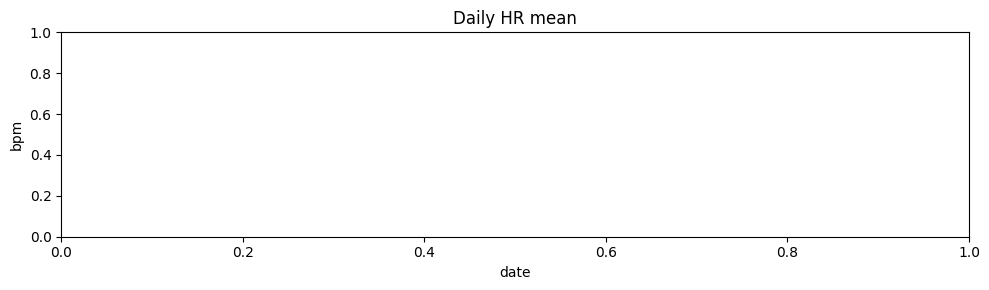

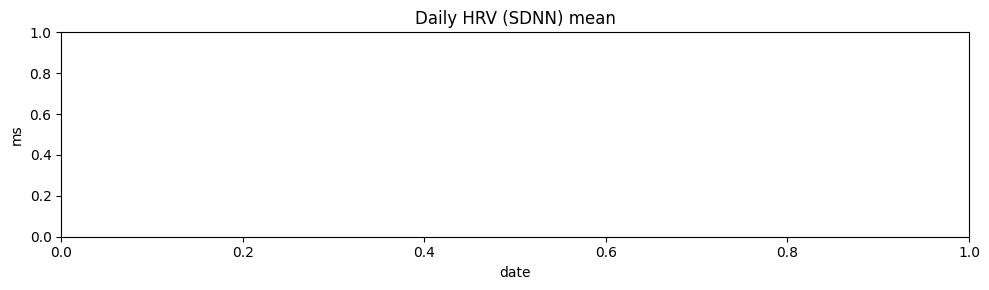

In [5]:
plt.figure(figsize=(10,3))
if not feat_cardio.empty and 'date' in feat_cardio:
    x = feat_cardio['date']
    y = feat_cardio.filter(regex=r'(^|_)hr_mean(_|$)', axis=1)
    if not y.empty:
        plt.plot(x, y.iloc[:,0])
plt.title('Daily HR mean')
plt.xlabel('date'); plt.ylabel('bpm'); plt.tight_layout()
plt.savefig(OUTDIR/'trend_hr_mean.png'); plt.show()

plt.figure(figsize=(10,3))
if not feat_cardio.empty and 'date' in feat_cardio:
    x = feat_cardio['date']
    y = feat_cardio.filter(regex=r'hrv.*(sdnn|sdnn_ms).*mean', axis=1)
    if not y.empty:
        plt.plot(x, y.iloc[:,0])
plt.title('Daily HRV (SDNN) mean')
plt.xlabel('date'); plt.ylabel('ms'); plt.tight_layout()
plt.savefig(OUTDIR/'trend_hrv_sdnn_mean.png'); plt.show()


## 04 | Distributions & correlations

In [6]:
num_cols = []
if not feat_cardio.empty:
    num_cols = [c for c in feat_cardio.columns if c != 'date' and pd.api.types.is_numeric_dtype(feat_cardio[c])]
    dfnum = feat_cardio[num_cols].copy()
    desc = dfnum.describe().T
    desc.to_csv(OUTDIR/'desc_cardio.csv')
    display(desc.head())

    # simple correlation heatmap-like (matplotlib only)
    corr = dfnum.corr(method='spearman')
    plt.figure(figsize=(6,5))
    plt.imshow(corr.values, aspect='auto')
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.index)), corr.index)
    plt.colorbar()
    plt.title('Spearman correlation (cardio features)')
    plt.tight_layout()
    plt.savefig(OUTDIR/'corr_cardio.png'); plt.show()


## 05 | Segment analysis (S1–S6)

In [7]:
if not feat_cardio.empty and 'segment_id' in feat_cardio.columns:
    seg_counts = feat_cardio['segment_id'].value_counts(dropna=False).sort_index()
    print('segment counts:\n', seg_counts)
    plt.figure(figsize=(6,3))
    plt.bar(seg_counts.index.astype(str), seg_counts.values)
    plt.title('Days per segment'); plt.tight_layout()
    plt.savefig(OUTDIR/'segments_counts.png'); plt.show()

    # boxplot HR by segment (first HR mean-like col)
    hrcols = [c for c in feat_cardio.columns if re.search(r'(^|_)hr_mean(_|$)', c)]
    if hrcols:
        import re
        data = [feat_cardio.loc[feat_cardio['segment_id']==sid, hrcols[0]].dropna().values for sid in sorted(feat_cardio['segment_id'].dropna().unique())]
        plt.figure(figsize=(8,3))
        plt.boxplot(data)
        plt.title(f'HR mean by segment ({hrcols[0]})')
        plt.tight_layout(); plt.savefig(OUTDIR/'box_hr_by_segment.png'); plt.show()


## 06 | Label preview (optional)

In [8]:
label_cols = [c for c in feat_dailyu.columns if c.lower()=='label'] if not feat_dailyu.empty else []
if label_cols:
    df = feat_dailyu[['date', label_cols[0]]].merge(feat_cardio, on='date', how='left')
    lab = label_cols[0]
    print('label distribution:\n', df[lab].value_counts(dropna=False))
    # HR by label (first HR mean-like col)
    hrcols = [c for c in feat_cardio.columns if re.search(r'(^|_)hr_mean(_|$)', c)]
    if hrcols:
        groups = [g.dropna().values for _, g in df.groupby(lab)[hrcols[0]]]
        plt.figure(figsize=(6,3))
        plt.boxplot(groups)
        plt.title(f'{hrcols[0]} by label')
        plt.tight_layout(); plt.savefig(OUTDIR/'box_hr_by_label.png'); plt.show()
else:
    print('No label column found; skipping label preview.')


No label column found; skipping label preview.


## 07 | Export EDA summary

In [9]:
summ = {
    'pid': PID,
    'snapshot': SNAP,
    'feat_cardio_rows': int(len(feat_cardio)) if not feat_cardio.empty else 0,
    'feat_daily_updated_rows': int(len(feat_dailyu)) if not feat_dailyu.empty else 0,
    'manifests': {
        'extract': extract_manifest.get('export_sha256',''),
        'cardio_outputs': list((cardio_manifest.get('outputs') or {}).keys()),
    }
}
(SNAPDIR/'eda_outputs'/'eda_summary.json').write_text(json.dumps(summ, indent=2), encoding='utf-8')
print('Wrote', SNAPDIR/'eda_outputs'/'eda_summary.json')


Wrote data_ai\P000001\snapshots\2025-09-29\eda_outputs\eda_summary.json
